# Multimodal RAG on "The Batch" atricles


This project aims to apply multimodal RAG-system on "The Batch" articles by deeplearning.ai

### Installing and importing dependencies

In [1]:
pip install -q transformers sentence-transformers langchain langchain_chroma langchain_cohere langchain-community langchain-openai bs4 nltk ragas==0.1.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.6.0 which is incompatible.
distributed 2024.7.1 requires dask==2024.7.1, but you have dask 2024.9.1 which is incompatible.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.2 which is incompatible.
jupyterlab 4.2.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which 

In [2]:
import os

import numpy as np 
import pandas as pd 

from langchain_openai import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.chains import RetrievalQA
from langchain import OpenAI
from langchain_text_splitters import HTMLSectionSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.text_splitter import CharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank
from transformers import AutoModel, AutoTokenizer

import torch

from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    answer_correctness,
    answer_similarity
)

from ragas import evaluate
from datasets import Dataset


from collections import defaultdict

import chromadb
from bs4 import BeautifulSoup
import nltk
from tqdm import tqdm

### Loading datasets

In [3]:
df = pd.read_csv('/kaggle/input/the-batch-articles-initial/articles_html.csv')
df.set_index('Url', inplace=True)
df

,Title,Publication_Date,Content
Url,,,
https://www.deeplearning.ai/the-batch/art-team-sells-robots-painting-for-1-1-million/,Art team sells robot’s painting for $1.1 milli...,"Nov 11, 2024","<article class=""pb-16 bg-white""><div class=""po..."
https://www.deeplearning.ai/the-batch/swe-kit-helps-developers-build-their-own-assistants/,SWE-Kit helps developers build their own assis...,"Nov 8, 2024","<article class=""pb-16 bg-white""><div class=""po..."
https://www.deeplearning.ai/the-batch/tensions-mount-as-automation-transforms-u-s-shipping-port/,Robots On the Loading Dock Tensions mount as a...,"Nov 06, 2024","<article class=""pb-16 bg-white""><div class=""po..."
https://www.deeplearning.ai/the-batch/social-media-bots-and-the-amplification-effect/,Social Media Bots and the Amplification Effect...,"Nov 06, 2024","<article class=""pb-16 bg-white""><div class=""po..."
https://www.deeplearning.ai/the-batch/openais-mle-bench-tests-ai-coding-agents/,When Agents Train Algorithms OpenAI’s MLE-benc...,"Nov 06, 2024","<article class=""pb-16 bg-white""><div class=""po..."
...,...,...,...
https://www.deeplearning.ai/the-batch/europe-tightens-the-screws/,Europe Tightens the Screws,"Apr 17, 2019","<article class=""pb-16 bg-white""><div class=""po..."
https://www.deeplearning.ai/the-batch/vcs-bet-on-nlp/,VCs Bet on NLP,"Apr 17, 2019","<article class=""pb-16 bg-white""><div class=""po..."
https://www.deeplearning.ai/the-batch/drones-go-commercial/,Drones Go Commercial,"Apr 17, 2019","<article class=""pb-16 bg-white""><div class=""po..."


In [4]:
image_captions_df = pd.read_csv('/kaggle/input/the-batch-articles-image-descriptions/image_captions.csv')
image_captions_df.set_index('URL', inplace=True)
image_captions_df = image_captions_df[['Description']]

image_captions_df

,Description
URL,
swe-kit-helps-developers-build-their-own-assistants/url_https_3A_2F_2Fdl-staging-website_ghost_io_2Fcontent_2Fimages_2F2024_2F11_2FDALL-E-2024-11-08-12_07_45---A-structured--orderly-line-of-robots-receiving-instructions-from-a-robot-boss_-The-robots-are-arranged-in-a-neat-l--1-_jpg_w_3840_q_75.jpg,A futuristic scene depicting a human in a suit...
tensions-mount-as-automation-transforms-u-s-shipping-port/url_https_3A_2F_2Fdl-staging-website_ghost_io_2Fcontent_2Fimages_2F2024_2F11_2Funnamed--24--1_gif_w_3840_q_75.jpg,**Summary:** The image depicts a modern shippi...
social-media-bots-and-the-amplification-effect/url_https_3A_2F_2Fdl-staging-website_ghost_io_2Fcontent_2Fimages_2F2024_2F11_2Funnamed--32--2_jpg_w_3840_q_75.jpg,A cartoonish yellow robot with a red megaphone...
openais-mle-bench-tests-ai-coding-agents/url_https_3A_2F_2Fdl-staging-website_ghost_io_2Fcontent_2Fimages_2F2024_2F11_2Funnamed--26--1_gif_w_3840_q_75.jpg,**Summary**: The image illustrates the MLE-ben...
compl-ai-study-measures-llms-compliance-with-eus-ai-act/url_https_3A_2F_2Fdl-staging-website_ghost_io_2Fcontent_2Fimages_2F2024_2F11_2Funnamed--25--1_gif_w_3840_q_75.jpg,**Summary:** The image illustrates the COMPL-A...
...,...
hidden-findings-revealed/url_https_3A_2F_2Fdl-staging-website_ghost_io_2Fcontent_2Fimages_2F2021_2F07_2FHidden-Findings-Revealed-1_png_w_3840_q_75.jpg,**Summary:** The image illustrates a four-step...
style-upgrade/url_https_3A_2F_2Fdl-staging-website_ghost_io_2Fcontent_2Fimages_2F2021_2F07_2F1_style20320sized-1024x577-1_png_w_3840_q_75.jpg,Image summary: The image showcases a grid of e...
why-ai-projects-fail-part-2-common-pitfalls/url_https_3A_2F_2Fdl-staging-website_ghost_io_2Fcontent_2Fimages_2F2021_2F06_2FAndrewLetter--1-_png_w_3840_q_75.jpg,A minimalist illustration of a friendly ghost ...


### Loading secrets

In [5]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ['OPENAI_API_KEY'] = user_secrets.get_secret("OPENAI_KEY")
os.environ["COHERE_API_KEY"] = user_secrets.get_secret("COHERE_SECRET")

## Processing

### Processing texts and chunking

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
def sliding_window(sentences, window_size, overlap):
    chunks = []
    for i in range(0, len(sentences), window_size - overlap):
        chunk = sentences[i:i + window_size]
        chunks.append(chunk)
    return chunks

In [8]:
processed_combined = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):    
    soup = BeautifulSoup(row['Content'], "html.parser")
    text_content = soup.get_text()
    processed_combined.append(text_content)


100%|██████████| 1654/1654 [00:02<00:00, 744.81it/s]


In [9]:
processed_combined_full = processed_combined + image_captions_df['Description'].to_numpy().tolist()

### Chunk and combine both extracted texts and image descriptions

In [10]:
document_chunk_list = []

window_size = 2 
overlap = 1     

for index, row in tqdm(df.iterrows(), total=df.shape[0]):    
    soup = BeautifulSoup(row['Content'], "html.parser")
    text_content = soup.get_text()

    sentences = nltk.tokenize.sent_tokenize(text_content)
    chunks = sliding_window(sentences, window_size, overlap)

    for i, chunk in enumerate(chunks):
        document_chunk_list.append(Document(page_content=''.join(chunk), metadata={"split_id": i, "doc_id": index, "type": "text", "image_url": ''}))

for index, row in tqdm(image_captions_df.iterrows(), total=image_captions_df.shape[0]):    

    sentences = nltk.tokenize.sent_tokenize(row['Description'])
    chunks = sliding_window(sentences, window_size, overlap)

    for i, chunk in enumerate(chunks):
        document_chunk_list.append(Document(page_content=''.join(chunk), metadata={"split_id": i, "doc_id": f'https://www.deeplearning.ai/the-batch/{index.split("/")[0]}/', "type": "image", "image_url": index}))


100%|██████████| 1607/1607 [00:00<00:00, 3093.64it/s]


In [11]:
len(document_chunk_list)

31375

## RAG initialization

### Embedding model init

In [12]:
#Defining the embedding function
model_name = "BAAI/bge-large-en-v1.5"
model_kwargs = {'device': 'cuda'}
encode_kwargs = {"normalize_embeddings": True}

embedding_function = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

### Vector store init

In [13]:
chroma_client = chromadb.Client()

vector_store = Chroma(
    collection_name="all_docs_collection",
    embedding_function=embedding_function,
    persist_directory="./all_docs_collection",  
)
        
vector_store.add_documents(document_chunk_list);


### Cohere reranker added for optimized results

In [14]:
llm = ChatOpenAI(model='gpt-4o', temperature=0.1)

retriever = vector_store.as_retriever(search_kwargs={"k": 10})

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

template = """Answer the question based only on the following context. If you cannot answer the question with the context, please respond with 'I don't know':

### CONTEXT
{context}

### QUESTION
Question: {question}
"""
prompt = PromptTemplate(
    template=template, 
    input_variables=[
        'context', 
        'question',
    ]
)

qa_chain = RetrievalQA.from_chain_type(llm=llm, 
                                       retriever=compression_retriever,     
                                       return_source_documents=True,
                                       chain_type_kwargs={"prompt": prompt}
)


## Evaluation

### **Text query sanity check**

In [15]:
question = "Elaborate on the misclassification in AI, emphasizing the potential for bias in ML models"
qa_chain.invoke({"query": question})

{'query': 'Elaborate on the misclassification in AI, emphasizing the potential for bias in ML models',
 'result': 'The misclassification in AI, as illustrated by the visual representation, underscores the potential for bias in machine learning models. This occurs when a model incorrectly labels an object, such as labeling a silhouette of a different color as "Banana" instead of correctly identifying it. Such errors highlight how biases present in the training data can be amplified when the model is applied to real-world conditions. These biases can significantly impact perception and decision-making, as they may lead to incorrect conclusions or actions based on flawed data interpretation. The ongoing discussion about bias in AI, particularly in datasets like ImageNet, indicates a need for greater education and awareness within the AI community to address and mitigate these issues effectively.',
 'source_documents': [Document(metadata={'doc_id': 'https://www.deeplearning.ai/the-batch/bi

### **Combined query (image + text)**

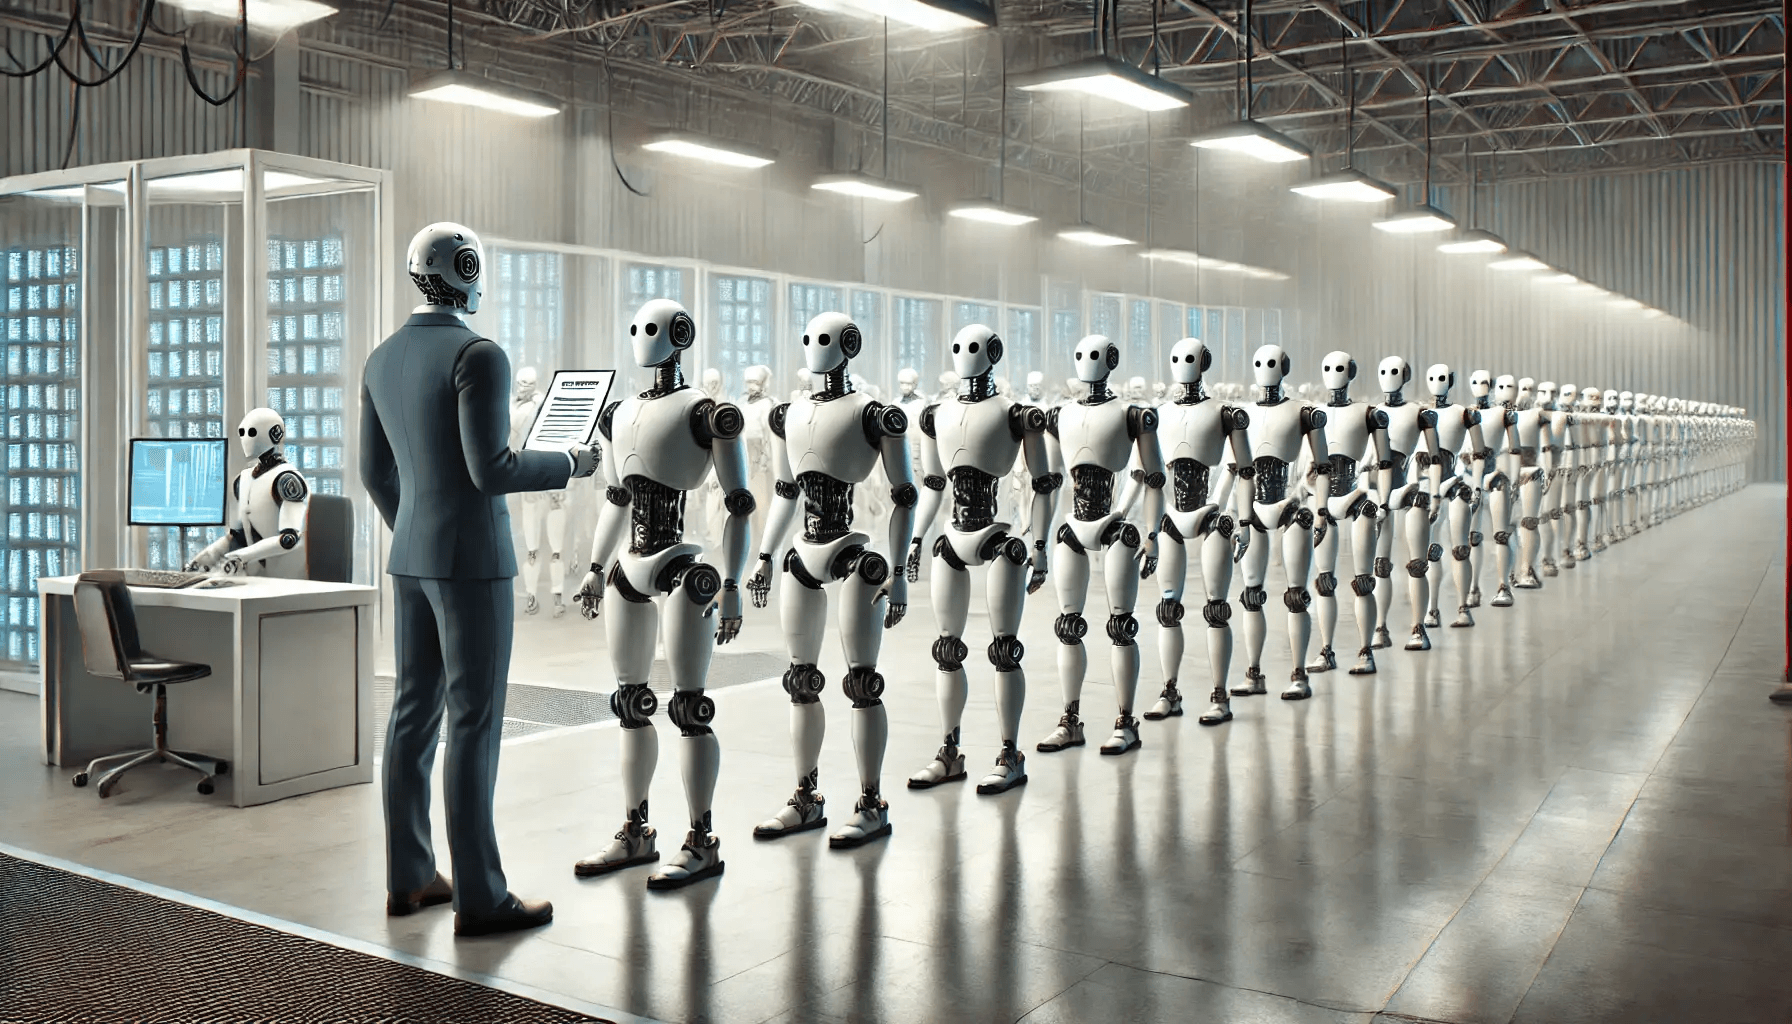

In [16]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://www.deeplearning.ai/_next/image/?url=https%3A%2F%2Fdl-staging-website.ghost.io%2Fcontent%2Fimages%2F2024%2F11%2FDALL-E-2024-11-08-12.07.45---A-structured--orderly-line-of-robots-receiving-instructions-from-a-robot-boss.-The-robots-are-arranged-in-a-neat-l--1-.jpg&w=3840&q=75")
img_bytes = BytesIO(response.content)
img = Image.open(img_bytes)
img

In [17]:
import base64

def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")
        
def encode_image_from_bytes(image):
    """Getting the base64 string"""
    return base64.b64encode(img_bytes.getvalue()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4o-mini", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(img_file):
    
    prompt = f"""You are an assistant tasked with generating a query summary for an input image. \
    This query will be embedded and used to retrieve the most relevant raw image from a database. \
    Provide a concise, retrieval-optimized description that captures the key visual details and context of the image. \
    """

    base64_image = encode_image_from_bytes(img_file)

    return image_summarize(base64_image, prompt)


def create_multi_model_query(question=None, image=None):
    query_arr = []
    if question:
        query_arr.append(question)

    if image:
        query_arr.append(f"Consider the following context: {generate_img_summaries(image)}")
        
    return " . ".join(str(element) for element in query_arr)

In [18]:
question_img = create_multi_model_query(question="", image=img_bytes)
question_img

'Consider the following context: A futuristic scene depicting a line of humanoid robots in a large, industrial space. In the foreground, a human in a suit is interacting with a robot, holding a document, while a second robot is seated at a desk using a computer. The background features numerous robots lined up, creating a sense of orderly assembly. The environment is well-lit with overhead lights, and the walls are lined with large windows, suggesting a high-tech facility focused on automation and robotics.'

In [19]:
qa_result = qa_chain.invoke({"query": question_img})
qa_result

{'query': 'Consider the following context: A futuristic scene depicting a line of humanoid robots in a large, industrial space. In the foreground, a human in a suit is interacting with a robot, holding a document, while a second robot is seated at a desk using a computer. The background features numerous robots lined up, creating a sense of orderly assembly. The environment is well-lit with overhead lights, and the walls are lined with large windows, suggesting a high-tech facility focused on automation and robotics.',
 'result': "I don't know.",
 'source_documents': [Document(metadata={'doc_id': 'https://www.deeplearning.ai/the-batch/swe-kit-helps-developers-build-their-own-assistants/', 'image_url': 'swe-kit-helps-developers-build-their-own-assistants/url_https_3A_2F_2Fdl-staging-website_ghost_io_2Fcontent_2Fimages_2F2024_2F11_2FDALL-E-2024-11-08-12_07_45---A-structured--orderly-line-of-robots-receiving-instructions-from-a-robot-boss_-The-robots-are-arranged-in-a-neat-l--1-_jpg_w_384

In [20]:
retrieved_img_url = qa_result["source_documents"][0].metadata["image_url"]

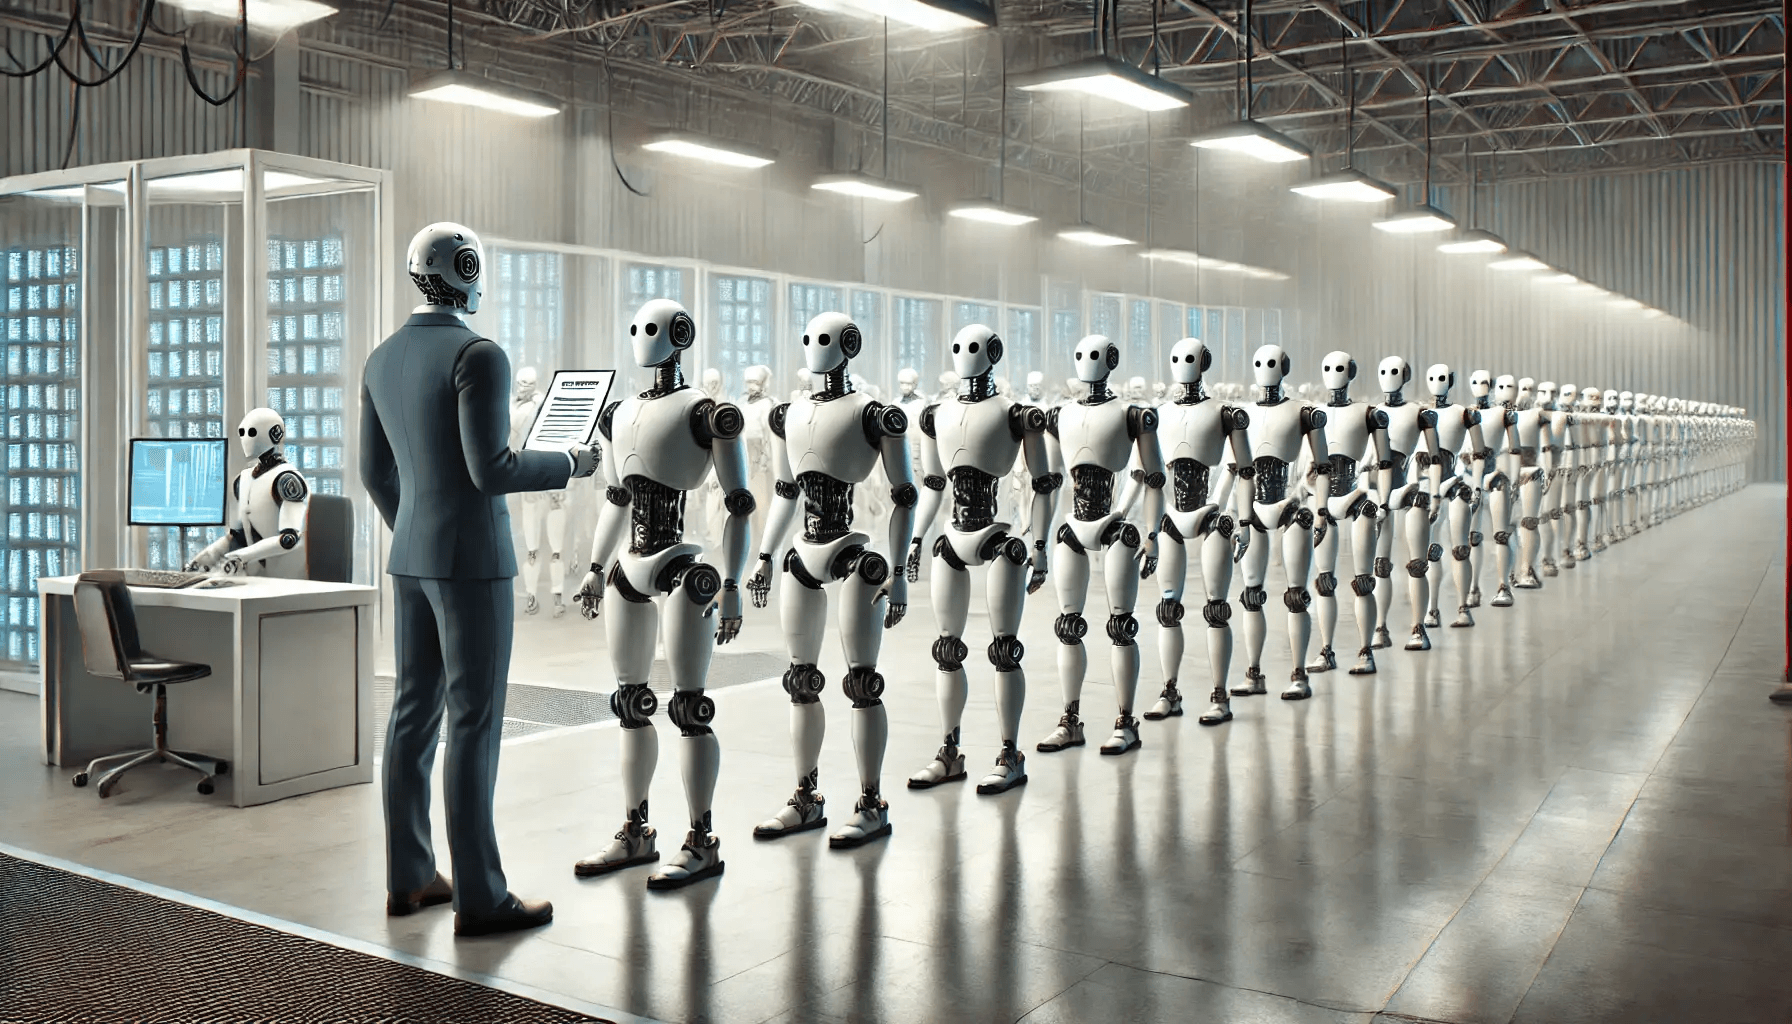

In [21]:
import PIL

PIL.Image.open(f"/kaggle/input/the-batch-articles-initial/images_clean/{retrieved_img_url}")

### Metric-based evaluation

In [22]:
from random import sample
import random

random.seed(42)

processed_sample = sample(processed_combined_full, 5)

In [23]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

question_schema = ResponseSchema(
    name="question",
    description="a question about the context."
)

question_response_schemas = [
    question_schema,
]

question_response_schemas


question_output_parser = StructuredOutputParser.from_response_schemas(question_response_schemas)
format_instructions = question_output_parser.get_format_instructions()

In [24]:
from langchain.prompts import ChatPromptTemplate

qa_template = """\
You are a University Professor creating a test for advanced students. Create a question that is specific to the context. Avoid creating generic or general questions. Don't say I don't know.

question: a question about the context.
answer: an answer from the context.

Format is the following:
*Question*: question
*Answer*:answer

context: {context}
"""

prompt_template = ChatPromptTemplate.from_template(template=qa_template)

synthetic_questions = []
synthetic_ground_truths = []

for sample_entry in processed_sample:
    
    message = prompt_template.format_messages(
        context=sample_entry,
        format_instructions=format_instructions
    )[0]
    sample_result = qa_chain.invoke((message).content)['result']
    synthetic_ground_truths.append(sample_result.split("*Answer*:")[1])
    synthetic_questions.append(sample_result.split("*Answer*:")[0].replace("*Question*:", ""))

In [25]:
from datasets import Dataset

questions = synthetic_questions
ground_truths = synthetic_ground_truths
references = processed_sample
answers = []
contexts = []

# Inference
for query in questions:
    qa_response = qa_chain.invoke({"query": query})
    answers.append(qa_response['result'])
    contexts.append([docs.page_content for docs in qa_response['source_documents']])

# To dict
data = {
    "question": questions,
    "answer": answers,
    "reference": references,
    "contexts": contexts,
    "ground_truth": ground_truths
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)


In [26]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset, 
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
        answer_correctness,
        answer_similarity
    ],
)

df_ragas = result.to_pandas()
df_ragas

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

,question,answer,reference,contexts,ground_truth,context_precision,faithfulness,answer_relevancy,context_recall,answer_correctness,answer_similarity
0,What does the image with a surveillance camer...,The image with a surveillance camera and a red...,Image depicts a surveillance camera mounted on...,[Image depicts a surveillance camera mounted o...,It represents opposition to real-time facial ...,0.833333,1.0,0.923142,1.000000,0.984693,0.938774
1,What specific objections did France and Germa...,I don't know.,"Amid growing worries about AI’s power, tech le...",[France led a group of countries that pushed f...,France and Germany objected to provisions in ...,0.583333,0.0,0.000000,0.000000,0.179911,0.719646
2,What methods did the Llama 3.1 team use to en...,I don't know.,Meta raised the bar for large language models ...,[They created the fine-tuning dataset and fine...,The Llama 3.1 team used several methods to en...,0.833333,0.0,0.000000,0.333333,0.181143,0.724573
3,"Based on the context provided, which AI job r...","Data Scientist, Machine Learning Engineer, Dat...",A chart illustrating various AI job roles and ...,"[Roles include Data Scientist, Machine Learnin...",The AI job roles represented in the chart are...,1.000000,1.0,0.879814,1.000000,0.978261,0.913043
4,What are the two initial products released by...,I don't know.,"A new consortium of companies, schools, and re...","[A new consortium of companies, schools, and r...",The two initial products released by MLCommon...,1.000000,0.0,0.000000,0.250000,0.183382,0.733526
